In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2
import os
import sys
import copy
import warnings
import logging

import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
sys.path.append('../')

from xgutils import *

In [25]:
nputil.makeGrid([0,0,0],[1,1,1],[256,256,256], flatten=True).size // (1024**2)

48

# PyTorch

In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn

## pytorch functionals

#### F.grid_sample(input, grid, mode='bilinear', padding_mode='zeros', align_corners=False)
https://pytorch.org/docs/stable/nn.functional.html#grid-sample

grid specifies the sampling pixel locations normalized by the input spatial dimensions. Therefore, it should have most values in the range of [-1, 1]. *For example, values x = -1, y = -1 is the left-top pixel of input, and values x = 1, y = 1 is the right-bottom pixel of input.*

Note that (x,y) in grid_sample is actually (h,w). Which means **you should first transpose your (x,y) coordinate.** Since -1 means index 0 and 1 means index max, there is **no need** to do further processing for *input* of Cartesian style

align_corners = False means 'in' mode for grid making. See the figure below.

<img src="assets/makegridmode.png" alt="drawing" width="200"/>

For VQVAE, the call should be like:

**F.grid_sample(input, grid, mode='nearest', padding_mode='border', align_corners=False)**

In [207]:
# F.grid_sample: the input grid's vertices location is produced by 'in' mode
# of nputil.makeGrid
input  = torch.tensor([[ [[0,1,2],[3,4,5],[6,7,8]] ]]).float() # [B, C, Hi, Wi]
print("Value looks like this in cartesian coordinates")
#print("2 5 8\n1 4 7\n0 3 6")
print(nputil.cart2image(input.squeeze().numpy()))
#npgrid = nputil.makeGrid(bb_min=[-1,-1], bb_max=[1,1.], mode='in', shape=[3,3], flatten=False)
#print("npgrid\n", npgrid)
npgrid = nputil.makeGrid(bb_min=[-1,-1.], bb_max=[1,1.], mode='in', shape=[3,3], flatten=True, indexing="ij")
# cartesian coord in matrix mode (-1,-1) -> upper left, (1,1) -> lower right, npgrid[0,1] means 0 x 1 y
grid   = torch.from_numpy(npgrid[None,None,...]).float()
print("Query probes:")
print(grid)
mode='bilinear'
padding_mode='zeros'
align_corners=False # in mode
print("Probed result:")
res=F.grid_sample(input, grid, mode=mode, padding_mode=padding_mode, align_corners=align_corners)
print(res)
print("Transposed Probed result:")
res=F.grid_sample(input, grid.flip(-1), mode=mode, padding_mode=padding_mode, align_corners=align_corners)
print(res)

single_coord = [-0.666667,.666667]
print("Test single coordinate:", single_coord)
res=F.grid_sample(input, torch.tensor([single_coord])[None,None,...], mode=mode, padding_mode=padding_mode, align_corners=align_corners)
print(res)

Value looks like this in cartesian coordinates
[[2. 5. 8.]
 [1. 4. 7.]
 [0. 3. 6.]]
Query probes:
tensor([[[[-0.6667, -0.6667],
          [-0.6667,  0.0000],
          [-0.6667,  0.6667],
          [ 0.0000, -0.6667],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.6667],
          [ 0.6667, -0.6667],
          [ 0.6667,  0.0000],
          [ 0.6667,  0.6667]]]])
Probed result:
tensor([[[[0., 3., 6., 1., 4., 7., 2., 5., 8.]]]])
Transposed Probed result:
tensor([[[[0., 1., 2., 3., 4., 5., 6., 7., 8.]]]])
Test single coordinate: [-0.666667, 0.666667]
tensor([[[[6.0000]]]])


In [67]:
# grid_sample 3d test
ind3d = torch.arange(8).reshape(2,2,2).float()[None,None,...]
print("input should looks like this in 3D:")
print("2 6\n0 4")
print("↑+y →+x")
print("---------")
print("3 7\n1 5")
print("↓ +z")
print("input", ind3d)
npgrid3d = nputil.makeGrid(bb_min=[-1,-1.,-1], bb_max=[1,1.,1], mode='in', shape=[2,2,2], flatten=True, indexing="ij")
grid3d   = torch.from_numpy(npgrid3d[None,None,None,...]).float()
probe  = grid3d
print("probe")
print(probe)
print("probe ind")
probe_ind = ptutil.point2index(torch.from_numpy(npgrid3d), grid_dim=2, ravel=True)
print(probe_ind)
coord_order = torch.tensor([2,1,0]).type_as(probe).long()
trans_probe = torch.index_select(probe, -1, coord_order)
print("trans_probe")
print(trans_probe)
sampled = F.grid_sample(ind3d, trans_probe, padding_mode='border', align_corners=False)
print(sampled)
print("I think this is correct, you do need to flip the coordinate to get grid_sample works as expected, that is x,y,z -> z,y,x")

input should looks like this in 3D:
2 6
0 4
↑+y →+x
---------
3 7
1 5
↓ +z
input tensor([[[[[0., 1.],
           [2., 3.]],

          [[4., 5.],
           [6., 7.]]]]])
probe
tensor([[[[[-0.5000, -0.5000, -0.5000],
           [-0.5000, -0.5000,  0.5000],
           [-0.5000,  0.5000, -0.5000],
           [-0.5000,  0.5000,  0.5000],
           [ 0.5000, -0.5000, -0.5000],
           [ 0.5000, -0.5000,  0.5000],
           [ 0.5000,  0.5000, -0.5000],
           [ 0.5000,  0.5000,  0.5000]]]]])
probe ind
tensor([0, 1, 2, 3, 4, 5, 6, 7])
trans_probe
tensor([[[[[-0.5000, -0.5000, -0.5000],
           [ 0.5000, -0.5000, -0.5000],
           [-0.5000,  0.5000, -0.5000],
           [ 0.5000,  0.5000, -0.5000],
           [-0.5000, -0.5000,  0.5000],
           [ 0.5000, -0.5000,  0.5000],
           [-0.5000,  0.5000,  0.5000],
           [ 0.5000,  0.5000,  0.5000]]]]])
tensor([[[[[0., 1., 2., 3., 4., 5., 6., 7.]]]]])
I think this is correct, you do need to flip the coordinate to get grid

In [189]:
pts = torch.rand(1,3,2)

In [194]:

npgrid1 = nputil.makeGrid(bb_min=[-1,-1.], bb_max=[1,1.], mode='on', shape=[6,6])
npgrid2 = nputil.makeGrid(bb_min=[-1,-1.], bb_max=[1,1.], mode='in', shape=[6,6])
npgrid3 = (np.random.rand(6*6,2)-.5)*2
voxel=point2voxel(torch.from_numpy(np.array([npgrid1,npgrid2,npgrid3])), grid_dim=16)

torch.Size([3, 16, 16])
tensor([[[1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
 

In [43]:
ptutil.unravel_index(torch.arange(256**3), (256,256,256))

tensor([[  0,   0,   0],
        [  0,   0,   1],
        [  0,   0,   2],
        ...,
        [255, 255, 253],
        [255, 255, 254],
        [255, 255, 255]])

In [97]:
A, B = 10, 5
x = torch.randn(A, B)
idx = torch.randint(0, B, (A,))
x[[0,1,2], [0,1,2]]

tensor([ 1.1301,  0.1324, -0.0260])

In [184]:
x = torch.tensor([1, 2, 3])
x.unsqueeze(1).expand(3,6).view(-1)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

# gather, scatter_add, scatter_max

In [164]:
# gather
t = torch.tensor([[1,2],[3,4]])
res = torch.gather(t, 1, torch.tensor([[0,0],[1,0]]))
print(res)
ind = torch.tensor([[0,1,2],[2,1,0],[0,0,0]])
val = torch.tensor([[1,2,3],[4,5,6],[7,8,9.]])
torch.gather(val, 1, ind)

#indX = ind.unsqueeze(-1).expand(-1, -1, dim_x)
#subX = X.gather(1, indX)

tensor([[1, 1],
        [4, 3]])


tensor([[1., 2., 3.],
        [6., 5., 4.],
        [7., 7., 7.]])

In [141]:
x = torch.rand(2, 3, 5)
print(x)
y = torch.zeros(2, 5, 5)
print(y.shape)
index = torch.tensor([[[0, 0, 0, 0, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]], [[0, 1, 2, 0, 0], [0, 0, 0, 1, 2], [1, 1, 1, 1, 1]]])
y.scatter_add_(1, index, x)
print(y)

tensor([[[0.1244, 0.8219, 0.9657, 0.1381, 0.5275],
         [0.5350, 0.0926, 0.9559, 0.0474, 0.5752],
         [0.6233, 0.2434, 0.8176, 0.2766, 0.9490]],

        [[0.5878, 0.0446, 0.8846, 0.8624, 0.0938],
         [0.2090, 0.8127, 0.7529, 0.3875, 0.2628],
         [0.1812, 0.4079, 0.6670, 0.0811, 0.3919]]])
torch.Size([2, 5, 5])
tensor([[[0.1244, 0.8219, 0.9657, 0.1381, 0.5275],
         [1.1583, 0.3360, 1.7735, 0.3241, 1.5243],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.7968, 0.8127, 0.7529, 0.8624, 0.0938],
         [0.1812, 0.4524, 0.6670, 0.4686, 0.3919],
         [0.0000, 0.0000, 0.8846, 0.0000, 0.2628],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])


In [145]:
# scatter_max
from torch_scatter import scatter_max

y = torch.zeros(2, 5, 5)
#src = torch.Tensor([[2, 0, 1, 4, 3], [0, 2, 1, 3, 4]])
#index = torch.tensor([[4, 5, 4, 2, 3], [0, 0, 2, 2, 1]])
#out = src.new_zeros((2, 6))

out, argmax = scatter_max(x.cuda(), index.cuda(), out=y.cuda(), dim=1)

print(out)
print(argmax)

tensor([[[0.1244, 0.8219, 0.9657, 0.1381, 0.5275],
         [0.6233, 0.2434, 0.9559, 0.2766, 0.9490],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.5878, 0.8127, 0.7529, 0.8624, 0.0938],
         [0.1812, 0.4079, 0.6670, 0.3875, 0.3919],
         [0.0000, 0.0000, 0.8846, 0.0000, 0.2628],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], device='cuda:0')
tensor([[[0, 0, 0, 0, 0],
         [2, 2, 1, 2, 2],
         [3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3]],

        [[0, 1, 1, 0, 0],
         [2, 2, 2, 1, 2],
         [3, 3, 0, 3, 1],
         [3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3]]], device='cuda:0')


# Fold & Unfold

In [15]:
import torch.nn.functional as F
windows = torch.arange(16).float().reshape(1,1,4,4)
print(windows)
unfolded = F.unfold(windows, kernel_size=2, stride=1)
print(unfolded)
print(unfolded.shape)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
tensor([[[ 0.,  1.,  2.,  4.,  5.,  6.,  8.,  9., 10.],
         [ 1.,  2.,  3.,  5.,  6.,  7.,  9., 10., 11.],
         [ 4.,  5.,  6.,  8.,  9., 10., 12., 13., 14.],
         [ 5.,  6.,  7.,  9., 10., 11., 13., 14., 15.]]])
torch.Size([1, 4, 9])


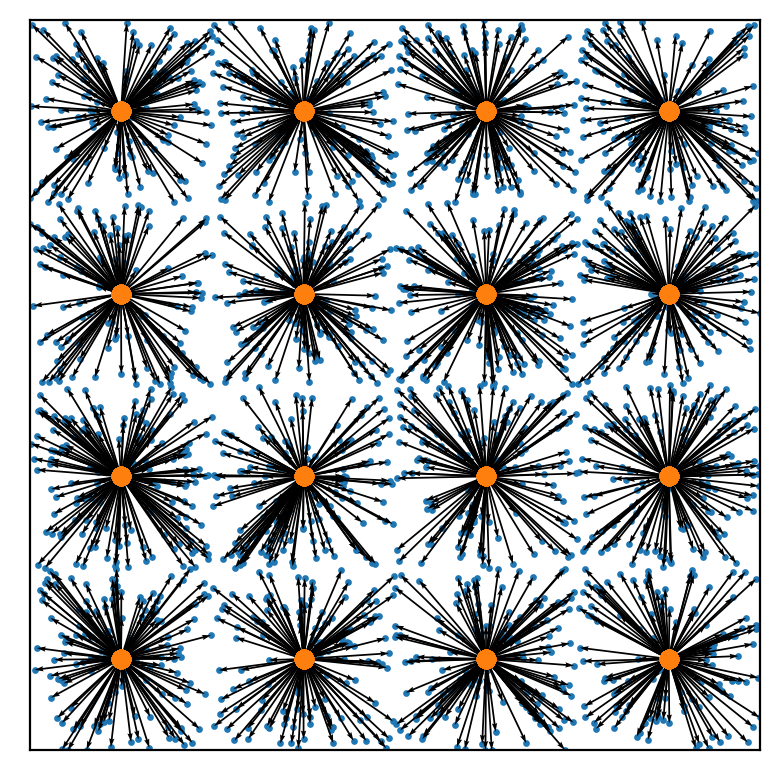

tensor([[-0.2500, -0.7500],
        [-0.2500,  0.2500],
        [ 0.7500, -0.7500],
        ...,
        [ 0.7500, -0.2500],
        [ 0.2500,  0.2500],
        [-0.2500,  0.7500]]) tensor([[-0.1256, -0.7070],
        [-0.2758,  0.2910],
        [ 0.8701, -0.7197],
        ...,
        [ 0.9015, -0.4089],
        [ 0.4614,  0.0461],
        [-0.0514,  0.5972]]) tensor([[ 0.1244,  0.0430],
        [-0.0258,  0.0410],
        [ 0.1201,  0.0303],
        ...,
        [ 0.1515, -0.1589],
        [ 0.2114, -0.2039],
        [ 0.1986, -0.1528]])


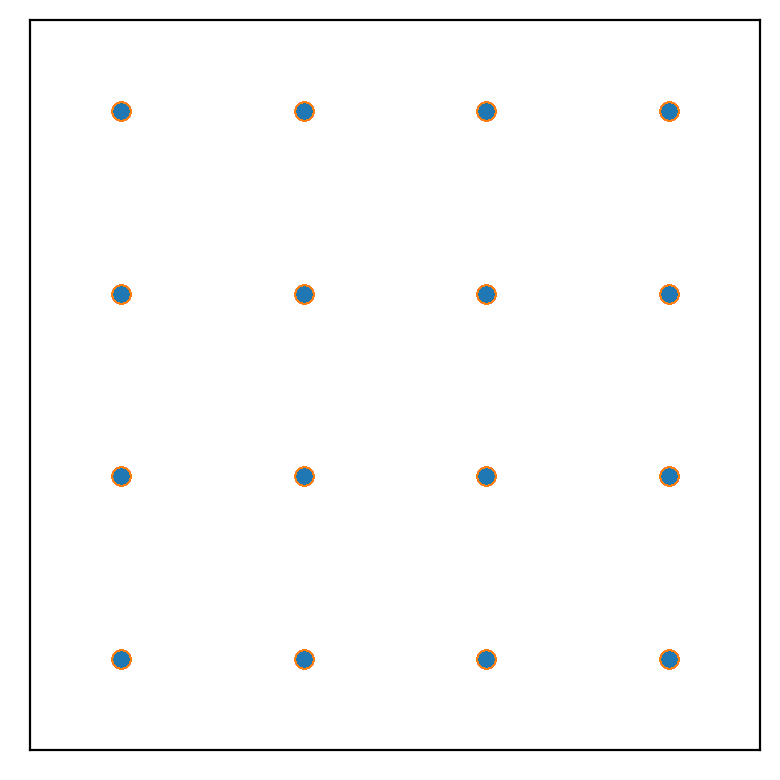

In [40]:
def ravel_unittest():
    idx = np.arange(9)
    npunravel = np.array(np.unravel_index(idx, (3,3))).swapaxes(0,-1)
    unraveled = ptutil.unravel_index(torch.from_numpy(idx)[None,...], (3,3))
    assert ( npunravel==(unraveled[0].numpy())).all(), print(npunravel,"\n",unraveled[0].numpy())
    raveled   = ptutil.ravel_index(unraveled, (3,3))
    assert ( idx==(raveled[0].numpy())).all(), print(idx,"\n",raveled[0].numpy())
    
    idx = np.arange(27)
    shape = (3,3,3)
    npunravel = np.array(np.unravel_index(idx, shape)).swapaxes(0,-1)
    unraveled = ptutil.unravel_index(torch.from_numpy(idx)[None,...], shape)
    assert ( npunravel==(unraveled[0].numpy())).all(), print(npunravel,"\n",unraveled[0].numpy())
    raveled   = ptutil.ravel_index(unraveled, shape)
    assert ( idx==(raveled[0].numpy())).all(), print(idx,"\n",raveled[0].numpy())
    print(unraveled)

def p2i_unittest():
    points = torch.rand(2000,2) * 2 - 1. #*1.6 - .8
    rind, grid_points, relative_diff = ptutil.point2index(points, ret_relative=True, grid_dim=4)
    fig, ax = visutil.newPlot(plotrange=np.array([[-1.,1.],[-1.,1.]]))
    ax.scatter(points.numpy()[:,0],      points.numpy()[:,1], s=2)
    ax.scatter(grid_points.numpy()[:,0], grid_points.numpy()[:,1], zorder=4)
    ax.quiver(grid_points.numpy()[:,0], grid_points.numpy()[:,1], relative_diff.numpy()[:,0], relative_diff.numpy()[:,1], angles='xy', scale_units='xy', scale=1)
    plt.show()
    
    revp = ptutil.index2point(rind, grid_dim=4)
    fig, ax = visutil.newPlot(plotrange=np.array([[-1.,1.],[-1.,1.]]))
    ax.scatter(grid_points.numpy()[:,0],      grid_points.numpy()[:,1], s=20, zorder=5)
    ax.scatter(revp.numpy()[:,0], revp.numpy()[:,1], zorder=4)
    # test for reshape
    
    print((grid_points),(points), (relative_diff))
    
#ravel_unittest()
p2i_unittest()

In [131]:
tind=torch.arange(16)[None,...]
coord=unravel_index(tind,(4,4)).reshape(4,4,2)
print(torch.flip(coord.transpose(0,1), [0]))
print(tind.reshape(4,4))
print(torch.flip(tind.reshape(4,4).transpose(0,1), [0]))
print(torch.flip(torch.flip(tind.reshape(4,4).transpose(0,1), [0]).transpose(0,1), [0]))
print(torch.flip(tind.reshape(4,4), [0]).transpose(0,1))


tensor([[[0, 3],
         [1, 3],
         [2, 3],
         [3, 3]],

        [[0, 2],
         [1, 2],
         [2, 2],
         [3, 2]],

        [[0, 1],
         [1, 1],
         [2, 1],
         [3, 1]],

        [[0, 0],
         [1, 0],
         [2, 0],
         [3, 0]]])
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])
tensor([[ 3,  7, 11, 15],
        [ 2,  6, 10, 14],
        [ 1,  5,  9, 13],
        [ 0,  4,  8, 12]])
tensor([[15, 14, 13, 12],
        [11, 10,  9,  8],
        [ 7,  6,  5,  4],
        [ 3,  2,  1,  0]])
tensor([[12,  8,  4,  0],
        [13,  9,  5,  1],
        [14, 10,  6,  2],
        [15, 11,  7,  3]])


In [138]:
torch.arange(16).view(-1,1).expand(-1,4).reshape(4,4,-1)

tensor([[[ 0,  0,  0,  0],
         [ 1,  1,  1,  1],
         [ 2,  2,  2,  2],
         [ 3,  3,  3,  3]],

        [[ 4,  4,  4,  4],
         [ 5,  5,  5,  5],
         [ 6,  6,  6,  6],
         [ 7,  7,  7,  7]],

        [[ 8,  8,  8,  8],
         [ 9,  9,  9,  9],
         [10, 10, 10, 10],
         [11, 11, 11, 11]],

        [[12, 12, 12, 12],
         [13, 13, 13, 13],
         [14, 14, 14, 14],
         [15, 15, 15, 15]]])

[array([[-1.,  0.,  1.],
       [-1.,  0.,  1.],
       [-1.,  0.,  1.]]), array([[-1., -1., -1.],
       [ 0.,  0.,  0.],
       [ 1.,  1.,  1.]])]


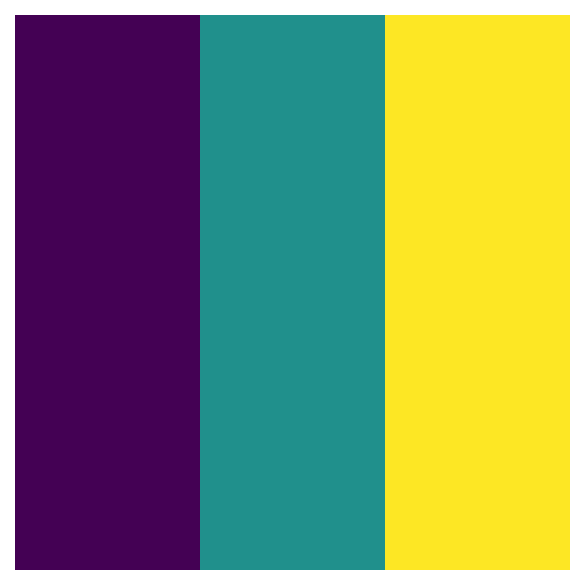

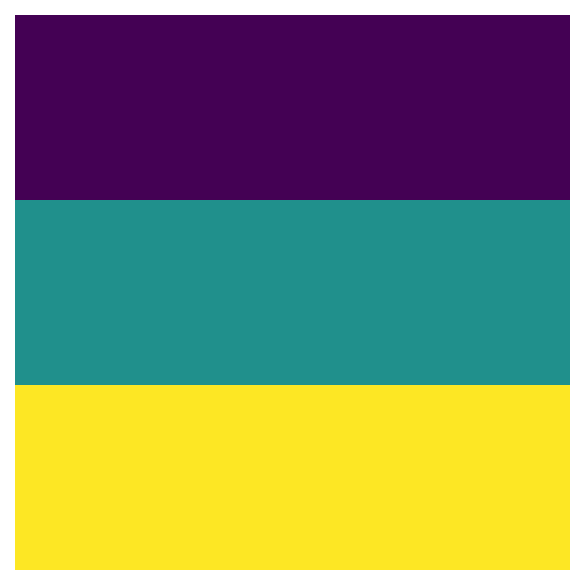

In [186]:
grd = nputil.makeGrid([-1,-1,],[1,1],[3,3], flatten=False)
#visutil.showImg(grd[...,0], scale=100, vmin=None, vmax=None)
#plt.show()
#visutil.showImg(grd[...,1], scale=100, vmin=None, vmax=None)
#plt.show()

grd2= np.linspace(-1,1,3)
grd2= np.meshgrid(grd2, grd2, sparse=False)
print(grd2)
visutil.showImg(grd2[0], scale=100, vmin=None, vmax=None)
plt.show()
visutil.showImg(grd2[1], scale=100, vmin=None, vmax=None)
plt.show()


In [218]:

A=torch.tensor([[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]], [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]])
print(A)
M = A.unfold(dimension=1, size=2, step=2).unfold(dimension=2, size=2, step=2)
M = A.unfold(dimension=1, size=(2,2), step=2)
M = M.contiguous().view(-1,4, 4)
print(M)

tensor([[[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12],
         [13, 14, 15, 16]],

        [[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12],
         [13, 14, 15, 16]]])


TypeError: unfold(): argument 'size' must be int, not tuple

[[10.  0.  8.]
 [ 6.  6. 13.]
 [14. 12.  9.]
 [ 7. 11.  3.]
 [11.  5.  6.]
 [ 4.  2. 10.]
 [ 5. 12. 14.]
 [10. 15.  0.]
 [14.  0.  7.]
 [ 8. 14.  2.]]


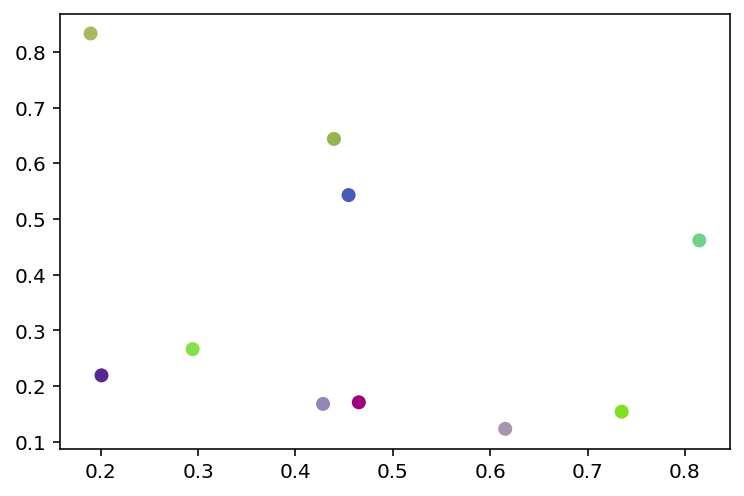

In [261]:
size=10
cmap = visutil.get_random_cmap(size)
with nputil.temp_seed(311):
    plt.scatter(np.random.rand(10), np.random.rand(10), c=np.random.rand(10), cmap=cmap)